## From apriori-testing-v8.py

In [1]:
import numpy as np
from random import sample

# Holdback-1 test for a set of association rules on a testset, also includes lift over random.
# We assume virtual items (if any) occur at the start of the basket:
# usually virtual items (eg age, gender) are not items that we wish to recommend hence testitemstart indicates 
# the start of the items that are to be tested (ie can be recommended).
# For each basket: do tpb (testsperbasket) tests by holding out in turn the first, second, third etc items in the testitems.
# Compute a random recommendation only when a rule-based recommendation is also made (for accurate comparison with the ruleset).
def rulehits_holdout_lift(testbaskets, rules, allitems, topN=10, tpb=5, itemstart=0):
    tothits = tottests = totrecs = totrhits = totrrecs = 0
    for testbasket in testbaskets:
        virtualitems = testbasket[:itemstart]
        testitems   = testbasket[itemstart:]
        numtests = min(len(testitems),tpb)
        for i in range(0,numtests):
            recs = execrules_anymatch(virtualitems+testitems[:i]+testitems[i+1:], rules, topN) # omit (holdout) the ith testitem
            nrecs = len(recs)
            if (nrecs > 0):
                recitems = set()
                for item, conf in recs: recitems.add(item) # strip out the confidences
                tothits = tothits + int(testitems[i] in recitems) # increment if testitem is in the recommended items
                totrecs = totrecs + nrecs
                tottests = tottests + 1
                # now do the random recommendations
                unseenitems = set(allitems) - set(testitems[:i]+testitems[i+1:]) # remove the holdout item
                recitems = sample(unseenitems,min(topN,len(unseenitems),nrecs))
                nrecs = len(recitems)
                totrhits = totrhits + int(testitems[i] in recitems) # increment if testitem is in the recommended items
                totrrecs = totrrecs + nrecs
    if (totrecs == 0 or totrrecs == 0 or totrhits == 0):
        print("no recommendations made, please check your inputs")
        return np.nan
    print("#holdbacks=",tottests,
          "recitems=",totrecs,
          "hits=",tothits,
          "({:.2f}%)".format(tothits*100/totrecs),
          "randrecitems=",totrrecs,
          "randhits=",totrhits,
          "({:.2f}%)".format(totrhits*100/totrrecs),
          "rulelift={:.2f}".format((tothits/totrecs)/(totrhits/totrrecs))) 
    return tothits, totrecs, tottests, totrhits, totrrecs

# to facilitate holdout sets > 1
# do split basket test for the rules (each testbasket = trainitemsubset + testitemsubset)
# the rules are executed using trainitemsubset for the LHS and the rule RHS is then compared with testitemsubset
def rulehits_splitbaskets(testbaskets, rules, topN=10):
    tothits = totrecs = 0
    uniqueitems = set()
    for trainbasket, testbasket in testbaskets:
        recs = execrules_anymatch(trainbasket, rules, topN)
        nrecs = len(recs)
        if (nrecs > 0):
            recitems = set()
            for item, conf in recs: recitems.add(item) # strip out the confidences
            tothits = tothits + len(recitems.intersection(testbasket))
            totrecs = totrecs + min(nrecs,len(testbasket))  # nrecs
            uniqueitems = uniqueitems.union(recitems)
    return tothits, totrecs, len(uniqueitems)

# do split basket test using random recommnendations
def randomhits_splitbaskets(testbaskets, allitemset, topN=10):
    tothits = totrecs = 0
    for trainbasket, testbasket in testbaskets:
        unseenitems = allitemset - set(trainbasket) # remove the seen (training) items
        recitems = set(sample(unseenitems,min(topN,len(unseenitems)))) # make topN random recommendations
        nrecs = len(recitems)
        if (nrecs > 0):
            tothits = tothits + len(recitems.intersection(testbasket))
            totrecs = totrecs + min(nrecs,len(testbasket))     # do we only count the size of the testset? (as max #recs possible) 
    return tothits, totrecs


# make and test recommendations from a set of classifiers (one per item) for the test users
def classifierhits_holdout_lift(classifiers,testset,allitems,topN=1):
    hits = randhits = tests = 0
    allpreds = list()
    for username in testset.index:
        user = testset.loc[[username]] # extract user as dataframe
        for testitem in allitems:
            if (user.loc[username,testitem] == 1): # its been bought by user hence can use as a holdback (test) item
                tests += 1
                probs = dict()
                unseenitems = list()
                user.loc[username,testitem] = 0 # blank out value
                # make a prediction (exec the corresponding tree) for every item not yet seen/bought by user
                for unseenitem in allitems: 
                    if (user.loc[username,unseenitem] == 0):  # its a valid unseen item
                        unseenitems.append(unseenitem)
                        inputvars = list(user.columns)
                        inputvars.remove(unseenitem)
                        pred = classifiers[unseenitem].predict_proba(user[inputvars])
                        probs[unseenitem] = pred[0][1] # get prob for class = True (the second element), Note: can check order returned with clf.classes_
                user.loc[username,testitem] = 1 # restore holdback value
                recs = sorted(probs.items(), key=lambda kv: kv[1], reverse=True) # sort unseen items by reverse probability
                numrecs = min(len(recs),topN)
                for item, conf in recs[0:numrecs]:
                    if (item == testitem):
                        hits += 1; break
                if (testitem in sample(unseenitems,numrecs)): randhits += 1 # make random recommedations           
                allpreds.append((testitem,recs[0:numrecs])) # record the recommendations made
    lift = hits/randhits if randhits > 0 else np.nan
    print("tests=",tests,"rulehits=",hits,"randhits=",randhits,"lift=", lift)
    return tests, hits, randhits, allpreds
    
#######################################################
# association rule execution
#######################################################

def execrules_allbaskets(baskets,rules,topN=10):
    recs = list()
    for basket in baskets: 
        rec = execrules_anymatch(basket,rules,topN)
        print(basket,"->",rec,"\n")
        recs.append(execrules_anymatch(basket,rules,topN))
    return (recs)

# execute a rule if any subset of the basket matches a rule LHS
# does not return any RHS item if its also within the LHS
# if many rules output (recommend) the same item then return the highest confidence for that item
# outputs a list of tuples: (item, confidence) for the topN items with highest confidence
def execrules_anymatch(itemset,rules,topN=10):
    preds = dict()
    for LHS, RHS, conf in rules:
        if LHS.issubset(itemset):
            for pitem in RHS:
                # ignore rules like A => A
                if not pitem in itemset:
                    if pitem in preds.keys():
                        preds[pitem] = max(preds[pitem],conf)
                    else:
                        preds[pitem] = conf                
    recs = sorted(preds.items(), key=lambda kv: kv[1], reverse=True)
    return recs[0:min(len(recs),topN)]

# only execute a rule if all of the basket matches the rule LHS
def execrules_exactmatch(itemset,rules,topN=10):
    preds = dict()
    for LHS, RHS, conf in rules:
        if LHS == set(itemset):
            for pitem in RHS:
                # ignore rules like A => A
                if not pitem in itemset:
                    if pitem in preds.keys():
                        preds[pitem] = max(preds[pitem],conf)
                    else:
                        preds[pitem] = conf                
    recs = sorted(preds.items(), key=lambda kv: kv[1], reverse=True)
    return recs[0:min(len(recs),topN)]

# return the set of all items in the ruleset RHS's
def RHSitems(rules):
    allitems = dict()
    for LHS, RHS, conf in rules:
        for item in RHS:
            if item in allitems.keys():
                allitems[item] = allitems[item] + 1
            else:
                allitems[item] = 1
    return allitems

# return the unique set of all items (as freq dictionary)
def itemcounts(itemsets):
    allitems = dict()
    for its in itemsets:
        for i in its:
            if i in allitems.keys():
                allitems[i] = allitems[i] + 1
            else:
                allitems[i] = 1  
    return allitems

def itemhist(idict):
    return sorted(idict.items(), key=lambda kv: kv[1], reverse=True)

# nice rule print (prints in reverse: confidence, RHS, KHS)
def showrules(rules, N=30):
    for L, R, C in rules: 
        print("{:.2f}".format(C),"\t",R,"<=\t",L)
        N = N-1
        if N <= 0: break
    
def clearall():
    get_ipython().magic('reset -sf')  # to clear all data

## From apriori-lib.py

In [2]:
from collections import defaultdict
from itertools import chain, combinations


def apriori(itemSetList, minSup, minConf):
    # get distinct items
    C1ItemSet = getItemSetFromList(itemSetList)
    # Final result, global frequent itemset
    globalFreqItemSet = dict()
    # Storing global itemset with support count
    globalItemSetWithSup = defaultdict(int)

    L1ItemSet = getAboveMinSup(C1ItemSet, itemSetList, minSup, globalItemSetWithSup)
    currentLSet = L1ItemSet
    k = 2

    # Calculating frequent item set
    while(currentLSet):
        # Storing frequent itemset
        globalFreqItemSet[k-1] = currentLSet
        # Self-joining Lk
        candidateSet = getUnion(currentLSet, k)
        # Perform subset testing and remove pruned supersets
        candidateSet = pruning(candidateSet, currentLSet, k-1)
        # Scanning itemSet for counting support
        currentLSet = getAboveMinSup(candidateSet, itemSetList, minSup, globalItemSetWithSup)
        k += 1

    rules = associationRule(globalFreqItemSet, globalItemSetWithSup, minConf)
    rules.sort(key=lambda x: x[2], reverse=True)

    return globalFreqItemSet, rules

    
def powerset(s):
    return chain.from_iterable(combinations(s, r) for r in range(1, len(s)))

def getAboveMinSup(itemSet, itemSetList, minSup, globalItemSetWithSup):
    freqItemSet = set()
    localItemSetWithSup = defaultdict(int)

    for item in itemSet:
        for itemSet in itemSetList:
            if item.issubset(itemSet):
                globalItemSetWithSup[item] += 1
                localItemSetWithSup[item] += 1

    for item, supCount in localItemSetWithSup.items():
        support = float(supCount / len(itemSetList))
        if(support >= minSup):
            freqItemSet.add(item)

    return freqItemSet


def getUnion(itemSet, length):
    return set([i.union(j) for i in itemSet for j in itemSet if len(i.union(j)) == length])


def pruning(candidateSet, prevFreqSet, length):
    tempCandidateSet = candidateSet.copy()
    for item in candidateSet:
        subsets = combinations(item, length)
        for subset in subsets:
            # if the subset is not in previous K-frequent get, then remove the set
            if(frozenset(subset) not in prevFreqSet):
                tempCandidateSet.remove(item)
                break
    return tempCandidateSet


def associationRule(freqItemSet, itemSetWithSup, minConf):
    rules = []
    for k, itemSet in freqItemSet.items():
        for item in itemSet:
            subsets = powerset(item)
            for s in subsets:
                confidence = float(itemSetWithSup[item] / itemSetWithSup[frozenset(s)])
                if(confidence > minConf):
                    rules.append([set(s), set(item.difference(s)), confidence])
    return rules


def getItemSetFromList(itemSetList):
    tempItemSet = set()

    for itemSet in itemSetList:
        for item in itemSet:
            tempItemSet.add(frozenset([item]))

    return tempItemSet


In [3]:
import os
import numpy as np
import pandas as pd
from random import sample 
import matplotlib.pyplot as plt

os.chdir(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1')
trans = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1\Groceries_dataset.csv') # load in the purchase tranactions
trans.columns = ['user','datetime','item']
trans

,user,datetime,item
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


In [4]:
allitems = np.unique(trans.item)
len(allitems) # derive the distinct items

167

In [5]:
# creating the item setlists
baskets = trans.groupby('user')['item'].apply(list)
baskets  # group transactions into baskets (a series of lists)

user
1000    [soda, canned beer, sausage, sausage, whole mi...
1001    [frankfurter, frankfurter, beef, sausage, whol...
1002    [tropical fruit, butter milk, butter, frozen v...
1003    [sausage, root vegetables, rolls/buns, deterge...
1004    [other vegetables, pip fruit, root vegetables,...
                              ...                        
4996    [dessert, salty snack, rolls/buns, misc. bever...
4997    [tropical fruit, white wine, whole milk, curd,...
4998                                   [rolls/buns, curd]
4999    [bottled water, butter milk, tropical fruit, b...
5000    [soda, bottled beer, fruit/vegetable juice, ro...
Name: item, Length: 3898, dtype: object

## (1A) Build and test association rules using kaggle groceries dataset 
## this has 167 distinct grocery items, format = purchase transactions, one row per transaction

In [6]:
# do some simple data visualisation/data exploration
itemfreqcnts = itemcounts(baskets) # count item frequencies
sorted(itemfreqcnts.items(), key=lambda kv: kv[1], reverse=True)[1:10] # reverse sort by frequency

[('other vegetables', 1898),
 ('rolls/buns', 1716),
 ('soda', 1514),
 ('yogurt', 1334),
 ('root vegetables', 1071),
 ('tropical fruit', 1032),
 ('bottled water', 933),
 ('sausage', 924),
 ('citrus fruit', 812)]

<BarContainer object of 20 artists>

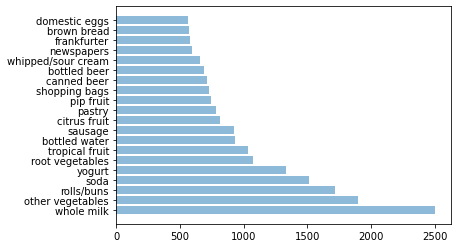

In [7]:
# display as histogram
rankeditems = [k for k,v in sorted(itemfreqcnts.items(), key=lambda kv: kv[1], reverse=True)]
frequencies = [v for k,v in sorted(itemfreqcnts.items(), key=lambda kv: kv[1], reverse=True)]
topN=20
plt.barh(rankeditems[0:topN], frequencies[0:topN], align='center', alpha=0.5)

In [8]:
# build a set of association rules, experiment using different support and confidence parameters
freqItemSet, rules = apriori(baskets, minSup=0.2, minConf=0.2)
len(rules) # 0

0

In [9]:
freqItemSet, rules = apriori(baskets, minSup=0.1, minConf=0.1)
len(rules) # 26

26

In [10]:
freqItemSet, rules = apriori(baskets, minSup=0.01, minConf=0.1)
len(rules) # 9726

9726

In [11]:
# examine the top rules and determine the number of unique items that the rules can recommend (target)
rules[0:10]

[[{'domestic eggs', 'meat'}, {'whole milk'}, 0.7843137254901961],
 [{'chocolate', 'fruit/vegetable juice'}, {'whole milk'}, 0.75],
 [{'bottled water', 'other vegetables', 'rolls/buns', 'yogurt'},
  {'whole milk'},
  0.7454545454545455],
 [{'bottled water', 'pip fruit', 'yogurt'},
  {'whole milk'},
  0.7407407407407407],
 [{'brown bread', 'rolls/buns', 'yogurt'}, {'whole milk'}, 0.7352941176470589],
 [{'bottled water', 'brown bread', 'other vegetables'},
  {'whole milk'},
  0.7230769230769231],
 [{'bottled beer', 'rolls/buns', 'yogurt'}, {'whole milk'}, 0.72],
 [{'curd', 'soda', 'yogurt'}, {'whole milk'}, 0.711864406779661],
 [{'other vegetables', 'rolls/buns', 'shopping bags', 'yogurt'},
  {'whole milk'},
  0.7090909090909091],
 [{'pastry', 'pip fruit', 'yogurt'}, {'whole milk'}, 0.7068965517241379]]

In [12]:
showrules(rules, N=50)

0.78 	 {'whole milk'} <=	 {'meat', 'domestic eggs'}
0.75 	 {'whole milk'} <=	 {'chocolate', 'fruit/vegetable juice'}
0.75 	 {'whole milk'} <=	 {'rolls/buns', 'yogurt', 'other vegetables', 'bottled water'}
0.74 	 {'whole milk'} <=	 {'pip fruit', 'yogurt', 'bottled water'}
0.74 	 {'whole milk'} <=	 {'rolls/buns', 'yogurt', 'brown bread'}
0.72 	 {'whole milk'} <=	 {'other vegetables', 'bottled water', 'brown bread'}
0.72 	 {'whole milk'} <=	 {'rolls/buns', 'yogurt', 'bottled beer'}
0.71 	 {'whole milk'} <=	 {'soda', 'yogurt', 'curd'}
0.71 	 {'whole milk'} <=	 {'rolls/buns', 'yogurt', 'other vegetables', 'shopping bags'}
0.71 	 {'whole milk'} <=	 {'pip fruit', 'yogurt', 'pastry'}
0.71 	 {'whole milk'} <=	 {'sausage', 'domestic eggs', 'rolls/buns'}
0.70 	 {'whole milk'} <=	 {'hamburger meat', 'pip fruit'}
0.70 	 {'whole milk'} <=	 {'yogurt', 'other vegetables', 'butter'}
0.70 	 {'whole milk'} <=	 {'cream cheese ', 'butter'}
0.70 	 {'whole milk'} <=	 {'yogurt', 'root vegetables', 'shopping b

In [13]:
ruleRHSitems = RHSitems(rules)
len(ruleRHSitems)

45

In [14]:
ruleRHSitems # show each unqiue targeted item and number of rules that recommend that item

{'whole milk': 2185,
 'other vegetables': 1540,
 'rolls/buns': 1331,
 'soda': 955,
 'yogurt': 924,
 'root vegetables': 530,
 'sausage': 533,
 'bottled water': 509,
 'tropical fruit': 471,
 'pastry': 283,
 'canned beer': 236,
 'shopping bags': 274,
 'whipped/sour cream': 169,
 'pip fruit': 266,
 'domestic eggs': 127,
 'bottled beer': 221,
 'citrus fruit': 278,
 'brown bread': 151,
 'fruit/vegetable juice': 116,
 'newspapers': 151,
 'frankfurter': 148,
 'butter': 124,
 'pork': 108,
 'curd': 121,
 'coffee': 79,
 'margarine': 88,
 'beef': 91,
 'chicken': 61,
 'chocolate': 50,
 'white bread': 45,
 'frozen vegetables': 71,
 'cream cheese ': 42,
 'berries': 19,
 'meat': 2,
 'UHT-milk': 20,
 'hamburger meat': 22,
 'dessert': 26,
 'napkins': 17,
 'frozen meals': 1,
 'sugar': 5,
 'beverages': 2,
 'salty snack': 3,
 'waffles': 5,
 'onions': 8,
 'ham': 1}

In [15]:
# to test the rules we first divide the baskets into training and test sets and then rebuild the ruleset
testsize = int(len(baskets)*0.1) # set the size of the test set
testids  = sample(list(baskets.index),testsize)
trainids = list(set(baskets.index) - set(testids))
trainbaskets = baskets[trainids]
testbaskets  = baskets[testids]

print("test size:", testsize)
print("No. of test names:", len(testids))
print("No. of train names:", len(trainids))
print("train shape:", trainbaskets.shape)
print("test shape:", testbaskets.shape)

test size: 389
No. of test names: 389
No. of train names: 3509
train shape: (3509,)
test shape: (389,)


In [16]:
# rebuild the ruleset using the training baskest only
freqItemSet, rules = apriori(trainbaskets, minSup=0.01, minConf=0.1)
len(rules) 

9422

In [17]:
# make recommendations for one basket (e.g. for one user at basket checkout time)
testbasket = testbaskets.iloc[1]
execrules_anymatch(testbasket, rules) # allows any subset of the testbasket to match a rule LHS

[('other vegetables', 0.5064935064935064),
 ('rolls/buns', 0.4935064935064935),
 ('soda', 0.4189189189189189),
 ('yogurt', 0.3783783783783784),
 ('tropical fruit', 0.31981981981981983),
 ('bottled water', 0.3153153153153153),
 ('sausage', 0.30180180180180183),
 ('root vegetables', 0.26523297491039427),
 ('canned beer', 0.2624113475177305),
 ('pastry', 0.2553191489361702)]

In [18]:
# make up a new basket usign any items in the inventory
testbasket = ['frozen meals','snack products']
execrules_anymatch(testbasket, rules)

[('whole milk', 0.5067264573991032),
 ('rolls/buns', 0.4618834080717489),
 ('other vegetables', 0.4618834080717489),
 ('yogurt', 0.34080717488789236),
 ('soda', 0.34080717488789236),
 ('tropical fruit', 0.28699551569506726),
 ('sausage', 0.2556053811659193),
 ('bottled water', 0.242152466367713),
 ('citrus fruit', 0.23318385650224216),
 ('root vegetables', 0.2242152466367713)]

In [19]:
# test the ruleset on the testset using holdout_1 testing ....
# we set topN = 5 and tests per basket (tpb) = 5
# are the rules better than random? check the lift over random

_ = rulehits_holdout_lift(testbaskets, rules, allitems, topN=5, tpb=5)

#holdbacks= 1822 recitems= 9103 hits= 407 (4.47%) randrecitems= 9103 randhits= 37 (0.41%) rulelift=11.00


## (1B) Explore applying association mining to a web browsing session.
## This dataset records visits to the microsoft website (www.microsoft.com) for a one week period
## each record is a cookieID plus a pagecategoryID (vroot ID). 
## Predicting the next webpagecategory (vroot) a user might view can be useful for website optimisation and/or
## for recommending unseen content

In [20]:
# load the pagecategory view events
trans = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1\anonymous-msweb-transactions.txt',sep = '\s+') 
trans.columns = ['user','item']
trans.item.nunique() # show the number of vroots

285

In [21]:
# load the category names
pagecatnames = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1\anonymous-vrootnames-msweb.csv') 
pagecatnames.columns = ['item','title','url']
pagecatnames['title'] = pagecatnames['title'].str.strip()
pagecatnames

,item,title,url
0,1287,International AutoRoute,/autoroute
1,1288,library,/library
2,1289,Master Chef Product Information,/masterchef
3,1297,Central America,/centroam
4,1215,For Developers Only Info,/developer
...,...,...,...
289,1219,Corporate Advertising Content,/ads
290,1030,Windows NT Server,/ntserver
291,1182,Fortran,/fortran
292,1100,MS in Education,/education


In [22]:
# join
trans = pd.merge(trans, pagecatnames, on="item")
trans

,user,item,title,url
0,10001,1000,regwiz,/regwiz
1,10010,1000,regwiz,/regwiz
2,10039,1000,regwiz,/regwiz
3,10073,1000,regwiz,/regwiz
4,10087,1000,regwiz,/regwiz
...,...,...,...,...
98649,37099,1281,IntelliMouse,/intellimouse
98650,39877,1282,home,/home
98651,41244,1282,home,/home
98652,41033,1283,Cinemainia,/cinemania


In [23]:
trans['title'].value_counts()

Free Downloads                         10836
Internet Explorer                       9383
Microsoft.com Search                    8463
isapi                                   5330
Products                                5108
                                       ...  
MS Solutions Framework                     1
Switching from Competitive Products        1
partner                                    1
mdsn                                       1
controls                                   1
Name: title, Length: 284, dtype: int64

In [24]:
allitems = np.unique(trans.title)
len(allitems) # get the distinct items

284

In [25]:
baskets = trans.groupby('user')['title'].apply(list)  # convert transactions into baskets (a series of lists)
baskets[0:30]

user
10001    [regwiz, Support Desktop, End User Produced View]
10002                    [Support Desktop, Knowledge Base]
10003    [Support Desktop, Knowledge Base, Microsoft.co...
10004                                             [Norway]
10005                                               [misc]
10006               [Knowledge Base, Microsoft.com Search]
10007                           [International IE content]
10008                               [Microsoft.com Search]
10009              [Free Downloads, Windows Family of OSs]
10010    [regwiz, Visual Basic, MS Office Development, ...
10011    [Excel, MS Excel, Products, isapi, MS PowerPoint]
10012                        [Developer Network, Visual C]
10013                                    [Typography Site]
10014                                              [Spain]
10015                        [Internet Information Server]
10016    [Web Site Builder's Gallery, Internet Site Con...
10017    [Products, Internet Site Construction for 

In [26]:
# do some simple data visualisation/data exploration
itemfreqcnts = itemcounts(baskets) # count item frequencies
sorted(itemfreqcnts.items(), key=lambda kv: kv[1], reverse=True) # reverse sort by frequency

[('Free Downloads', 10836),
 ('Internet Explorer', 9383),
 ('Microsoft.com Search', 8463),
 ('isapi', 5330),
 ('Products', 5108),
 ('Windows Family of OSs', 4628),
 ('Support Desktop', 4451),
 ('Internet Site Construction for Developers', 3220),
 ('Knowledge Base', 2968),
 ("Web Site Builder's Gallery", 2123),
 ('Windows95 Support', 1791),
 ('MS Office Info', 1506),
 ('Developer Workshop', 1500),
 ('Games', 1446),
 ('Windows 95', 1160),
 ('Windows NT Server', 1115),
 ('SiteBuilder Network Membership', 1110),
 ('Developer Network', 1087),
 ('regwiz', 912),
 ('International IE content', 865),
 ('MS Word News', 842),
 ('Corporate Desktop Evaluation', 759),
 ('End User Produced View', 749),
 ('Office Free Stuff', 728),
 ('Training', 716),
 ('Visual Basic', 698),
 ('SP Referral (ART)', 672),
 ('Jakarta', 670),
 ('IE Support', 636),
 ('ActiveX Technology Development', 602),
 ('Windows NT Workstation', 584),
 ('MS Office', 574),
 ('FrontPage', 548),
 ('Internet Information Server', 521),
 ('I

<BarContainer object of 20 artists>

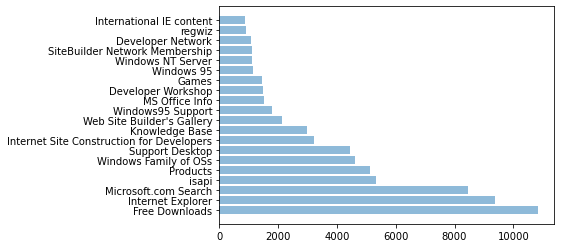

In [27]:
# display as histogram
rankeditems = [k for k,v in sorted(itemfreqcnts.items(), key=lambda kv: kv[1], reverse=True)]
frequencies = [v for k,v in sorted(itemfreqcnts.items(), key=lambda kv: kv[1], reverse=True)]
topN=20
plt.barh(rankeditems[0:topN], frequencies[0:topN], align='center', alpha=0.5)

In [28]:
# build a set of association rules, experiment using different support and confidence parameters
freqItemSet, rules = apriori(baskets, minSup=0.01, minConf=0.1)
len(rules)

467

In [29]:
# examine the top rules and determine the number of unique items that the rules can recommend (target)
rules[0:5]

[[{'Windows 95', 'Windows95 Support'},
  {'Windows Family of OSs'},
  0.9739884393063584],
 [{'Windows 95', 'isapi'}, {'Windows Family of OSs'}, 0.9670886075949368],
 [{'Free Downloads', 'Windows 95'},
  {'Windows Family of OSs'},
  0.9445628997867804],
 [{'Windows 95'}, {'Windows Family of OSs'}, 0.9146551724137931],
 [{'Free Downloads', 'Windows Family of OSs', 'Windows95 Support'},
  {'isapi'},
  0.9073569482288828]]

In [30]:
showrules(rules, N=467)

0.97 	 {'Windows Family of OSs'} <=	 {'Windows 95', 'Windows95 Support'}
0.97 	 {'Windows Family of OSs'} <=	 {'isapi', 'Windows 95'}
0.94 	 {'Windows Family of OSs'} <=	 {'Free Downloads', 'Windows 95'}
0.91 	 {'Windows Family of OSs'} <=	 {'Windows 95'}
0.91 	 {'isapi'} <=	 {'Free Downloads', 'Windows Family of OSs', 'Windows95 Support'}
0.91 	 {'isapi'} <=	 {'Free Downloads', 'Windows95 Support'}
0.90 	 {'Internet Site Construction for Developers'} <=	 {'SiteBuilder Network Membership', 'Developer Workshop'}
0.89 	 {'Windows Family of OSs'} <=	 {'Products', 'Windows 95'}
0.89 	 {'isapi'} <=	 {'Support Desktop', 'Windows Family of OSs', 'Windows95 Support'}
0.88 	 {'isapi'} <=	 {'Windows95 Support', 'Knowledge Base'}
0.88 	 {'isapi'} <=	 {'Windows Family of OSs', 'Windows95 Support'}
0.87 	 {'isapi'} <=	 {'Support Desktop', 'Windows95 Support', 'Knowledge Base'}
0.84 	 {'isapi'} <=	 {'Windows95 Support'}
0.84 	 {'Free Downloads'} <=	 {'Windows Family of OSs', 'Internet Explorer', 'is

In [31]:
# make up a new basket usign any items in the inventory
testbasket = ['India','Games']
execrules_anymatch(testbasket, rules)

[('Free Downloads', 0.35408022130013833), ('Products', 0.24343015214384509)]

In [32]:
ruleRHSitems = RHSitems(rules)
len(ruleRHSitems)

20

In [33]:
ruleRHSitems # show each unqiue targeted item and number of rules that recommend that item

{'Windows Family of OSs': 67,
 'isapi': 96,
 'Internet Site Construction for Developers': 13,
 'Free Downloads': 100,
 'Support Desktop': 64,
 'Internet Explorer': 40,
 'Windows95 Support': 44,
 'Knowledge Base': 47,
 'Microsoft.com Search': 58,
 'Products': 43,
 'MS Office Info': 2,
 'regwiz': 1,
 'SiteBuilder Network Membership': 7,
 'Windows 95': 10,
 'Office Free Stuff': 2,
 'Developer Workshop': 10,
 "Web Site Builder's Gallery": 2,
 'Corporate Desktop Evaluation': 1,
 'Windows NT Server': 1,
 'Windows NT Workstation': 1}

In [34]:
# to test the rules we first divide the baskets into training and test sets and then rebuild the ruleset
testsize = int(len(baskets)*0.1) # set the size of the test set
testids  = sample(list(baskets.index),testsize)
trainids = list(set(baskets.index) - set(testids))
trainbaskets = baskets[trainids]
testbaskets  = baskets[testids]

print("test size:", testsize)
print("No. of test names:", len(testids))
print("No. of train names:", len(trainids))
print("train shape:", trainbaskets.shape)
print("test shape:", testbaskets.shape)

test size: 3271
No. of test names: 3271
No. of train names: 29440
train shape: (29440,)
test shape: (3271,)


In [35]:
# build a set of association rules, experiment using different support and confidence parameters
freqItemSet, rules = apriori(trainbaskets, minSup=0.01, minConf=0.01)
len(rules)

644

In [36]:
# make recommendations for one basket (e.g. for one user at basket checkout time)
testbasket = testbaskets.iloc[1]
execrules_anymatch(testbasket, rules) # allows any subset of the testbasket to match a rule LHS

[('isapi', 0.4399899774492608),
 ('Knowledge Base', 0.4054121773991481),
 ('Microsoft.com Search', 0.3578050613881233),
 ('Free Downloads', 0.2671009771986971),
 ('Products', 0.24029065397143573),
 ('Windows95 Support', 0.21874216988223502),
 ('Windows Family of OSs', 0.18992733650714105),
 ('Internet Explorer', 0.17840140315710348)]

In [37]:
# test the ruleset on the testset using holdout_1 testing ....
# we set topN = 5 and tests per basket (tpb) = 5
# are the rules better than random? check the lift over random

_ = rulehits_holdout_lift(testbaskets, rules, allitems, topN=3, tpb=5)

#holdbacks= 7095 recitems= 20881 hits= 3870 (18.53%) randrecitems= 20881 randhits= 75 (0.36%) rulelift=51.60


### (1C) Build and test associations using grocery data that also contains demographic information for the users.
### This dataset contains only has 11 grocery items. It is in tabular format (one row per user).
### We will do two tests and compare the results: 
### test1 ~ using only the grocery items to build the rules
### test2 ~ using both grocery items and user demographics (as virtual items) to build the rules

In [38]:
users = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1\baskets.txt')
users

,cardid,value,pmethod,sex,homeown,income,age,fruitveg,freshmeat,dairy,cannedveg,cannedmeat,frozenmeal,beer,wine,softdrink,fish,confectionery
0,39808,42.7123,CHEQUE,M,NO,27000,46,F,T,T,F,F,F,F,F,F,F,T
1,67362,25.3567,CASH,F,NO,30000,28,F,T,F,F,F,F,F,F,F,F,T
2,10872,20.6176,CASH,M,NO,13200,36,F,F,F,T,F,T,T,F,F,T,F
3,26748,23.6883,CARD,F,NO,12200,26,F,F,T,F,F,F,F,T,F,F,F
4,91609,18.8133,CARD,M,YES,11000,24,F,F,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31384,37.2056,CARD,M,NO,27500,27,F,F,F,T,F,F,F,F,F,F,F
996,63996,13.7353,CHEQUE,F,NO,22600,23,F,F,F,T,F,F,F,F,F,T,F
997,99025,29.0798,CARD,M,YES,27400,42,F,T,F,F,F,F,F,F,F,F,F
998,95921,34.8576,CASH,F,YES,23300,43,T,F,F,F,F,F,F,T,F,F,T


In [39]:
############# test1 ###############

# for test1 we remove the demographic & account columns - leave only the items purchased
users.drop(['cardid','value', 'pmethod', 'sex', 'homeown', 'income', 'age'], inplace=True, axis=1) # only leave the groceries
users

,fruitveg,freshmeat,dairy,cannedveg,cannedmeat,frozenmeal,beer,wine,softdrink,fish,confectionery
0,F,T,T,F,F,F,F,F,F,F,T
1,F,T,F,F,F,F,F,F,F,F,T
2,F,F,F,T,F,T,T,F,F,T,F
3,F,F,T,F,F,F,F,T,F,F,F
4,F,F,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...,...
995,F,F,F,T,F,F,F,F,F,F,F
996,F,F,F,T,F,F,F,F,F,T,F
997,F,T,F,F,F,F,F,F,F,F,F
998,T,F,F,F,F,F,F,T,F,F,T


In [40]:
# before converting to baskets, we replace the value T in all of the grocery variables to the groceryname
# if we dont do this then the one-hot coded column names are assigned the values "T" and "F" 
groceryitems = list(users.columns)
groceryitems

['fruitveg',
 'freshmeat',
 'dairy',
 'cannedveg',
 'cannedmeat',
 'frozenmeal',
 'beer',
 'wine',
 'softdrink',
 'fish',
 'confectionery']

In [41]:
for col in groceryitems: 
    users[col] = np.where(users[col]=='T', col, '')  # is the item was not in the basket then leave value blank

users

,fruitveg,freshmeat,dairy,cannedveg,cannedmeat,frozenmeal,beer,wine,softdrink,fish,confectionery
0,,freshmeat,dairy,,,,,,,,confectionery
1,,freshmeat,,,,,,,,,confectionery
2,,,,cannedveg,,frozenmeal,beer,,,fish,
3,,,dairy,,,,,wine,,,
4,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
995,,,,cannedveg,,,,,,,
996,,,,cannedveg,,,,,,fish,
997,,freshmeat,,,,,,,,,
998,fruitveg,,,,,,,wine,,,confectionery


In [42]:
# convert each dataframe row into a basket (a list) and
# assemble all baskets into a series (suitable for the apriori library)

#first we define a function to do this (highlight all of the function and execute)
def df2Baskets(users):
    baskets = users.values.tolist()
    newbaskets = list()
    for basket in baskets:
        while ('' in basket): basket.remove('') # remove the empty items
        if (len(basket) > 0): newbaskets.append(basket)
    return(pd.Series(newbaskets))

#now apply the function    
baskets = df2Baskets(users)
baskets

0        [freshmeat, dairy, confectionery]
1               [freshmeat, confectionery]
2      [cannedveg, frozenmeal, beer, fish]
3                            [dairy, wine]
4                  [freshmeat, wine, fish]
                      ...                 
935                            [cannedveg]
936                      [cannedveg, fish]
937                            [freshmeat]
938        [fruitveg, wine, confectionery]
939      [dairy, softdrink, confectionery]
Length: 940, dtype: object

In [43]:
# split the baskets into train and test sets
testsize = 100
testids  = sample(list(baskets.index),testsize)
trainids = list(set(baskets.index) - set(testids))
trainbaskets = baskets[trainids]
testbaskets  = baskets[testids]

In [44]:
# build the rules, remember to experiment with min.support and min.confidence
freqItemSet, rules = apriori(baskets, minSup=0.01, minConf=0.1) 
len(rules) 

1442

In [45]:
# do holdout1 test
_ = rulehits_holdout_lift(testbaskets, rules, groceryitems, topN=5, tpb=5)

#holdbacks= 287 recitems= 1430 hits= 228 (15.94%) randrecitems= 1430 randhits= 180 (12.59%) rulelift=1.27


In [46]:
# try different values for topN, what do the results tell you?
# (note: try running the below a few times, the lifts may vary due to the randomness of the random recommendations)
for n in range(1,10):
    _ = rulehits_holdout_lift(testbaskets, rules, groceryitems, topN=n, tpb=5)

#holdbacks= 287 recitems= 287 hits= 104 (36.24%) randrecitems= 287 randhits= 34 (11.85%) rulelift=3.06
#holdbacks= 287 recitems= 574 hits= 138 (24.04%) randrecitems= 574 randhits= 58 (10.10%) rulelift=2.38
#holdbacks= 287 recitems= 861 hits= 183 (21.25%) randrecitems= 861 randhits= 104 (12.08%) rulelift=1.76
#holdbacks= 287 recitems= 1148 hits= 207 (18.03%) randrecitems= 1148 randhits= 142 (12.37%) rulelift=1.46
#holdbacks= 287 recitems= 1430 hits= 228 (15.94%) randrecitems= 1430 randhits= 167 (11.68%) rulelift=1.37
#holdbacks= 287 recitems= 1707 hits= 247 (14.47%) randrecitems= 1707 randhits= 207 (12.13%) rulelift=1.19
#holdbacks= 287 recitems= 1974 hits= 267 (13.53%) randrecitems= 1974 randhits= 244 (12.36%) rulelift=1.09
#holdbacks= 287 recitems= 2176 hits= 282 (12.96%) randrecitems= 2176 randhits= 275 (12.64%) rulelift=1.03
#holdbacks= 287 recitems= 2290 hits= 286 (12.49%) randrecitems= 2290 randhits= 283 (12.36%) rulelift=1.01


In [47]:
########## test2 ##############

# for test2 we build and test rules that also include the card holders demographics
users = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1\baskets.txt')  # re-read the data
users.drop(['cardid'], inplace=True, axis=1) # only drop cardID, keep all other fields
users

,value,pmethod,sex,homeown,income,age,fruitveg,freshmeat,dairy,cannedveg,cannedmeat,frozenmeal,beer,wine,softdrink,fish,confectionery
0,42.7123,CHEQUE,M,NO,27000,46,F,T,T,F,F,F,F,F,F,F,T
1,25.3567,CASH,F,NO,30000,28,F,T,F,F,F,F,F,F,F,F,T
2,20.6176,CASH,M,NO,13200,36,F,F,F,T,F,T,T,F,F,T,F
3,23.6883,CARD,F,NO,12200,26,F,F,T,F,F,F,F,T,F,F,F
4,18.8133,CARD,M,YES,11000,24,F,F,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37.2056,CARD,M,NO,27500,27,F,F,F,T,F,F,F,F,F,F,F
996,13.7353,CHEQUE,F,NO,22600,23,F,F,F,T,F,F,F,F,F,T,F
997,29.0798,CARD,M,YES,27400,42,F,T,F,F,F,F,F,F,F,F,F
998,34.8576,CASH,F,YES,23300,43,T,F,F,F,F,F,F,T,F,F,T


In [48]:
# the numerical fields must be converted to categorical variables for association mining
# create a function to convert a number into a category based on a set of thresholds
def tobucket(val,name,thresholds):
    prevthresh = 0
    for thresh in thresholds:
        if val <= thresh: return f'{name}{prevthresh}-{thresh}'
        prevthresh = thresh
    return f'{name}>={thresh}' 

# apply the function to the numerical variables
users['value']  = [tobucket(x,'transval:',[10,20,30,40]) for x in users['value']]
users['income'] = [tobucket(x,'income:',[10000,20000,30000]) for x in users['income']]
users['age']    = [tobucket(x,'age:',[10,20,30,40]) for x in users['age']]
users

,value,pmethod,sex,homeown,income,age,fruitveg,freshmeat,dairy,cannedveg,cannedmeat,frozenmeal,beer,wine,softdrink,fish,confectionery
0,transval:>=40,CHEQUE,M,NO,income:20000-30000,age:>=40,F,T,T,F,F,F,F,F,F,F,T
1,transval:20-30,CASH,F,NO,income:20000-30000,age:20-30,F,T,F,F,F,F,F,F,F,F,T
2,transval:20-30,CASH,M,NO,income:10000-20000,age:30-40,F,F,F,T,F,T,T,F,F,T,F
3,transval:20-30,CARD,F,NO,income:10000-20000,age:20-30,F,F,T,F,F,F,F,T,F,F,F
4,transval:10-20,CARD,M,YES,income:10000-20000,age:20-30,F,F,F,F,F,F,F,F,F,F,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,transval:30-40,CARD,M,NO,income:20000-30000,age:20-30,F,F,F,T,F,F,F,F,F,F,F
996,transval:10-20,CHEQUE,F,NO,income:20000-30000,age:20-30,F,F,F,T,F,F,F,F,F,T,F
997,transval:20-30,CARD,M,YES,income:20000-30000,age:>=40,F,T,F,F,F,F,F,F,F,F,F
998,transval:30-40,CASH,F,YES,income:20000-30000,age:>=40,T,F,F,F,F,F,F,T,F,F,T


In [49]:
# before converting to baskets, we replace the value T in all of the grocery variables to the groceryname
for col in groceryitems: users[col] = np.where(users[col]=='T', col, '') 
# also do same for homeown variable
users['homeown'] = np.where(users['homeown']=='YES', 'homeown', '') 
users

,value,pmethod,sex,homeown,income,age,fruitveg,freshmeat,dairy,cannedveg,cannedmeat,frozenmeal,beer,wine,softdrink,fish,confectionery
0,transval:>=40,CHEQUE,M,,income:20000-30000,age:>=40,,freshmeat,dairy,,,,,,,,confectionery
1,transval:20-30,CASH,F,,income:20000-30000,age:20-30,,freshmeat,,,,,,,,,confectionery
2,transval:20-30,CASH,M,,income:10000-20000,age:30-40,,,,cannedveg,,frozenmeal,beer,,,fish,
3,transval:20-30,CARD,F,,income:10000-20000,age:20-30,,,dairy,,,,,wine,,,
4,transval:10-20,CARD,M,homeown,income:10000-20000,age:20-30,,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,transval:30-40,CARD,M,,income:20000-30000,age:20-30,,,,cannedveg,,,,,,,
996,transval:10-20,CHEQUE,F,,income:20000-30000,age:20-30,,,,cannedveg,,,,,,fish,
997,transval:20-30,CARD,M,homeown,income:20000-30000,age:>=40,,freshmeat,,,,,,,,,
998,transval:30-40,CASH,F,homeown,income:20000-30000,age:>=40,fruitveg,,,,,,,wine,,,confectionery


In [50]:
baskets = df2Baskets(users)
baskets

0      [transval:>=40, CHEQUE, M, income:20000-30000,...
1      [transval:20-30, CASH, F, income:20000-30000, ...
2      [transval:20-30, CASH, M, income:10000-20000, ...
3      [transval:20-30, CARD, F, income:10000-20000, ...
4      [transval:10-20, CARD, M, homeown, income:1000...
                             ...                        
995    [transval:30-40, CARD, M, income:20000-30000, ...
996    [transval:10-20, CHEQUE, F, income:20000-30000...
997    [transval:20-30, CARD, M, homeown, income:2000...
998    [transval:30-40, CASH, F, homeown, income:2000...
999    [transval:30-40, CASH, M, income:20000-30000, ...
Length: 1000, dtype: object

In [51]:
# divide into training and testsets using same indexes (same trainids and testids) as used in test1 above
trainbaskets = baskets[trainids]
testbaskets  = baskets[testids]

In [52]:
# build a new ruleset and examine the top rules (by confidence)
# can you draw any obvious conclusions by inspecting the rules (e.g. make any easy discoveries)?
freqItemSet, rules = apriori(trainbaskets, minSup=0.05, minConf=0.1); len(rules) 
showrules(rules)

1.00 	 {'wine'} <=	 {'income:20000-30000', 'transval:>=40', 'F', 'confectionery'}
1.00 	 {'income:10000-20000'} <=	 {'frozenmeal', 'beer', 'cannedveg', 'CARD'}
1.00 	 {'wine'} <=	 {'income:20000-30000', 'F', 'transval:30-40', 'confectionery'}
1.00 	 {'income:20000-30000'} <=	 {'F', 'transval:30-40', 'confectionery', 'wine'}
1.00 	 {'beer'} <=	 {'income:10000-20000', 'cannedveg', 'M', 'homeown', 'frozenmeal'}
1.00 	 {'cannedveg'} <=	 {'income:10000-20000', 'M', 'beer', 'homeown', 'frozenmeal'}
1.00 	 {'frozenmeal'} <=	 {'income:10000-20000', 'M', 'cannedveg', 'beer', 'CASH'}
1.00 	 {'beer'} <=	 {'income:10000-20000', 'M', 'cannedveg', 'CASH', 'frozenmeal'}
1.00 	 {'cannedveg'} <=	 {'income:10000-20000', 'M', 'beer', 'CASH', 'frozenmeal'}
1.00 	 {'income:10000-20000'} <=	 {'beer', 'M', 'cannedveg', 'CASH', 'frozenmeal'}
1.00 	 {'frozenmeal'} <=	 {'income:10000-20000', 'beer', 'cannedveg', 'M', 'CARD'}
1.00 	 {'cannedveg'} <=	 {'income:10000-20000', 'beer', 'M', 'CARD', 'frozenmeal'}
1.00

In [53]:
# the rules may contain non-grocery item in their RHS
# we must remove these since our goal is only to recommend groceryitems
groceryrules =list()
for LHS, RHS, conf in rules:
    intersect = set(groceryitems).intersection(RHS)
    if len(intersect) > 0: 
        groceryrules.append([LHS,intersect,conf])       
len(groceryrules)
showrules(groceryrules) # examine the top rules (by confidence)

1.00 	 {'wine'} <=	 {'income:20000-30000', 'transval:>=40', 'F', 'confectionery'}
1.00 	 {'wine'} <=	 {'income:20000-30000', 'F', 'transval:30-40', 'confectionery'}
1.00 	 {'beer'} <=	 {'income:10000-20000', 'cannedveg', 'M', 'homeown', 'frozenmeal'}
1.00 	 {'cannedveg'} <=	 {'income:10000-20000', 'M', 'beer', 'homeown', 'frozenmeal'}
1.00 	 {'frozenmeal'} <=	 {'income:10000-20000', 'M', 'cannedveg', 'beer', 'CASH'}
1.00 	 {'beer'} <=	 {'income:10000-20000', 'M', 'cannedveg', 'CASH', 'frozenmeal'}
1.00 	 {'cannedveg'} <=	 {'income:10000-20000', 'M', 'beer', 'CASH', 'frozenmeal'}
1.00 	 {'frozenmeal'} <=	 {'income:10000-20000', 'beer', 'cannedveg', 'M', 'CARD'}
1.00 	 {'cannedveg'} <=	 {'income:10000-20000', 'beer', 'M', 'CARD', 'frozenmeal'}
1.00 	 {'beer'} <=	 {'income:10000-20000', 'M', 'cannedveg', 'CARD', 'frozenmeal'}
0.99 	 {'frozenmeal'} <=	 {'income:10000-20000', 'beer', 'cannedveg', 'M'}
0.99 	 {'cannedveg'} <=	 {'income:10000-20000', 'beer', 'frozenmeal', 'M'}
0.99 	 {'beer'}

In [54]:
# do holdout test, does the demographic information inprove the reommendation performance?
# (note: try running the below a few times, the lifts may vary due to the randomness of the random recommendations)
for n in range(1,10):
    _ = rulehits_holdout_lift(testbaskets, groceryrules, groceryitems, topN=n, tpb=5, itemstart=6)

#holdbacks= 249 recitems= 249 hits= 88 (35.34%) randrecitems= 249 randhits= 31 (12.45%) rulelift=2.84
#holdbacks= 249 recitems= 498 hits= 114 (22.89%) randrecitems= 498 randhits= 65 (13.05%) rulelift=1.75
#holdbacks= 249 recitems= 747 hits= 141 (18.88%) randrecitems= 747 randhits= 89 (11.91%) rulelift=1.58
#holdbacks= 249 recitems= 996 hits= 171 (17.17%) randrecitems= 996 randhits= 124 (12.45%) rulelift=1.38
#holdbacks= 249 recitems= 1245 hits= 192 (15.42%) randrecitems= 1245 randhits= 164 (13.17%) rulelift=1.17
#holdbacks= 249 recitems= 1484 hits= 213 (14.35%) randrecitems= 1484 randhits= 175 (11.79%) rulelift=1.22
#holdbacks= 249 recitems= 1683 hits= 234 (13.90%) randrecitems= 1683 randhits= 194 (11.53%) rulelift=1.21
#holdbacks= 249 recitems= 1824 hits= 240 (13.16%) randrecitems= 1824 randhits= 227 (12.45%) rulelift=1.06
#holdbacks= 249 recitems= 1910 hits= 248 (12.98%) randrecitems= 1910 randhits= 231 (12.09%) rulelift=1.07


### (1D) compare the recommendations obtained using the above association rules with the recommendations obtained
### using a decision tree classifier (or any other supervised prediction model type you choose) to build one decision model per item.
### This is also a familiarity exercise for using scikitlearn prediction models and decisiontrees

In [70]:
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [85]:
####################################################
# (step1) load and preprocess the data
# preproceesing includes one-hot encoding the categorical variables
users = pd.read_csv(r'C:\Users\xBaka\Notebooks\School\Day 7\workshop1\baskets.txt') 
del users['cardid'] 

In [86]:
# swap the value T/F in all of the grocery variables to the grocery item name (this aids the onehot coding below)
# if we dont do this then the one-hot coded column names are assigned the values "T" and "F" 
groceryitems = ['fruitveg', 'freshmeat', 'dairy', 'cannedveg', 'cannedmeat','frozenmeal', 'beer', 'wine', 'softdrink', 'fish', 'confectionery']
for col in groceryitems:
    users[col] = np.where(users[col]=='T', col, 'none') 
users['homeown'] = np.where(users['homeown']=='YES', 'homeown', 'none')  # also do same for homeown variable

In [87]:
# onehot encode all of the categorical variables
# after one-hot coding a variable, we delete the original (unencoded) variable
catvars = set(users.columns)-set(('value','income','age')); catvars
for v in catvars:
    onehot = pd.get_dummies(users[v])
    if 'none' in list(onehot.columns): onehot.drop('none', inplace=True, axis=1)
    users.drop(v, inplace=True, axis = 1)
    users = users.join(onehot)

In [88]:
# view the preprocessed dataset (do a visual check for correctness)
users

,value,income,age,cannedveg,softdrink,cannedmeat,freshmeat,wine,F,M,beer,frozenmeal,confectionery,homeown,fruitveg,dairy,CARD,CASH,CHEQUE,fish
0,42.7123,27000,46,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
1,25.3567,30000,28,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
2,20.6176,13200,36,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1
3,23.6883,12200,26,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0
4,18.8133,11000,24,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,37.2056,27500,27,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
996,13.7353,22600,23,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1
997,29.0798,27400,42,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0
998,34.8576,23300,43,0,0,0,0,1,1,0,0,0,1,1,1,0,0,1,0,0


In [89]:
####################################################
# (step2) Build and test a decision tree for one item, with no pruning

# create train and test split
testsize = int(len(users)*0.2) # set the size of the test set (20%)
testnames = set(sample(list(users.index),testsize))
trainnames = set(users.index) - testnames
train = users.loc[trainnames,]
test = users.loc[testnames]

print("test size:", testsize)
print("No. of test names:", len(testnames))
print("No. of train names:", len(trainnames))
print("train shape:", train.shape)
print("test shape:", test.shape)

test size: 200
No. of test names: 200
No. of train names: 800
train shape: (800, 20)
test shape: (200, 20)


In [90]:
# build the decision tree
target = 'fruitveg' # select the target item, any item will do
inputvars = list(set(users.columns) - set([target]))
tclf = tree.DecisionTreeClassifier()
tclf.fit(train[inputvars],train[target])

DecisionTreeClassifier()

In [91]:
# view the tree method1
text_representation = tree.export_text(tclf, feature_names=inputvars)
print(text_representation)

|--- age <= 23.50
|   |--- fish <= 0.50
|   |   |--- freshmeat <= 0.50
|   |   |   |--- income <= 11050.00
|   |   |   |   |--- CARD <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- CARD >  0.50
|   |   |   |   |   |--- class: 1
|   |   |   |--- income >  11050.00
|   |   |   |   |--- income <= 15250.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- income >  15250.00
|   |   |   |   |   |--- value <= 12.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- value >  12.84
|   |   |   |   |   |   |--- value <= 26.00
|   |   |   |   |   |   |   |--- value <= 14.68
|   |   |   |   |   |   |   |   |--- value <= 13.91
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- value >  13.91
|   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |--- value >  14.68
|   |   |   |   |   |   |   |   |--- softdrink <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- sof

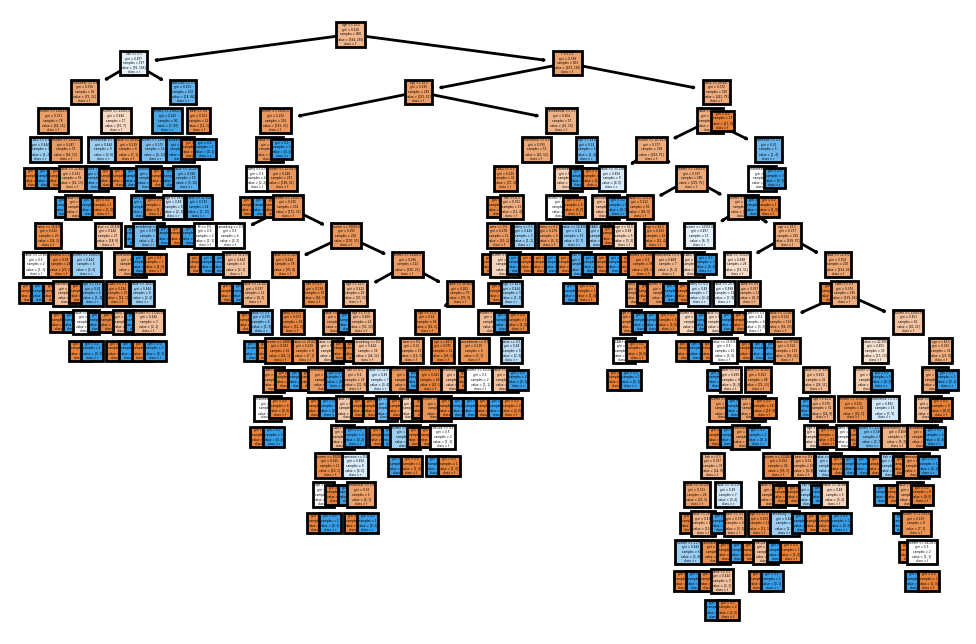

In [92]:
# view the tree method2
plt.rcParams['figure.dpi'] = 200 # adjust to get the plot resolution you want
_ = tree.plot_tree(tclf, feature_names=inputvars, class_names=target, filled=True)

In [93]:
# test the tree
preds = tclf.predict(test[inputvars])
print(classification_report(test[target],preds))
print(confusion_matrix(test[target], preds)) # rows = actual, cols = preds, eg precision for class 0 = (0,0)/((0,0)+(1,0))

              precision    recall  f1-score   support

           0       0.74      0.73      0.74       137
           1       0.43      0.44      0.44        63

    accuracy                           0.64       200
   macro avg       0.59      0.59      0.59       200
weighted avg       0.64      0.64      0.64       200

[[100  37]
 [ 35  28]]


In [94]:
# try some tree pruning to improve prediction accuracy (experiment with different pruning amounts to try to get best accuracy)
tclf = tree.DecisionTreeClassifier(min_samples_leaf=20)
tclf.fit(train[inputvars],train[target])
preds = tclf.predict(test[inputvars]); preds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0], dtype=uint8)

In [95]:
predsa = tclf.predict_proba(test[inputvars])
predsa

array([[0.86363636, 0.13636364],
       [0.92857143, 0.07142857],
       [0.65384615, 0.34615385],
       [0.54545455, 0.45454545],
       [0.54545455, 0.45454545],
       [0.54545455, 0.45454545],
       [0.65384615, 0.34615385],
       [0.94871795, 0.05128205],
       [0.7       , 0.3       ],
       [0.79166667, 0.20833333],
       [0.83333333, 0.16666667],
       [0.81818182, 0.18181818],
       [0.85714286, 0.14285714],
       [0.94871795, 0.05128205],
       [0.74074074, 0.25925926],
       [0.78571429, 0.21428571],
       [0.78571429, 0.21428571],
       [0.57142857, 0.42857143],
       [0.91304348, 0.08695652],
       [0.45833333, 0.54166667],
       [0.95238095, 0.04761905],
       [0.74074074, 0.25925926],
       [0.625     , 0.375     ],
       [0.74074074, 0.25925926],
       [0.5       , 0.5       ],
       [0.55      , 0.45      ],
       [0.58333333, 0.41666667],
       [0.79166667, 0.20833333],
       [0.95238095, 0.04761905],
       [0.78571429, 0.21428571],
       [0.

In [96]:
# has the accuracy improved? if not then try a different amount of pruning or type of pruning
print(classification_report(test[target],preds))
print(confusion_matrix(test[target], preds))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       137
           1       0.70      0.33      0.45        63

    accuracy                           0.74       200
   macro avg       0.73      0.63      0.64       200
weighted avg       0.74      0.74      0.71       200

[[128   9]
 [ 42  21]]


In [97]:
####################################################
# (step3) build a tree for each grocery item and use these trees to make and test recommendations

# build the trees (one per grocery item) and store in a dictionary
trees = dict()
for target in groceryitems:
    inputvars = list(users.columns)
    inputvars.remove(target)
    clf = tree.DecisionTreeClassifier(min_samples_leaf=20)
    clf.fit(train[inputvars],train[target])
    print(target,'tree size=',clf.tree_.node_count) # size of the tree
    trees[target] = clf

fruitveg tree size= 61
freshmeat tree size= 57
dairy tree size= 59
cannedveg tree size= 59
cannedmeat tree size= 57
frozenmeal tree size= 61
beer tree size= 55
wine tree size= 61
softdrink tree size= 61
fish tree size= 55
confectionery tree size= 59


In [98]:
# do the test for a range of topN values
# are the results better than the association rule results?
# (note: try running the below a few times, the lifts may vary due to the randomness of the random recommendations)

for n in range(1,10):        
    _ = classifierhits_holdout_lift(trees, test, groceryitems, topN=n)

tests= 598 rulehits= 241 randhits= 65 lift= 3.707692307692308
tests= 598 rulehits= 296 randhits= 140 lift= 2.1142857142857143
tests= 598 rulehits= 340 randhits= 253 lift= 1.3438735177865613
tests= 598 rulehits= 401 randhits= 282 lift= 1.4219858156028369
tests= 598 rulehits= 448 randhits= 387 lift= 1.1576227390180878
tests= 598 rulehits= 505 randhits= 465 lift= 1.086021505376344
tests= 598 rulehits= 536 randhits= 514 lift= 1.0428015564202335
tests= 598 rulehits= 564 randhits= 561 lift= 1.0053475935828877
tests= 598 rulehits= 585 randhits= 583 lift= 1.0034305317324186
